# Лабораторная работа 1. Нейронные сети.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за всю работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_01.ipynb.

# Часть 1. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [1]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

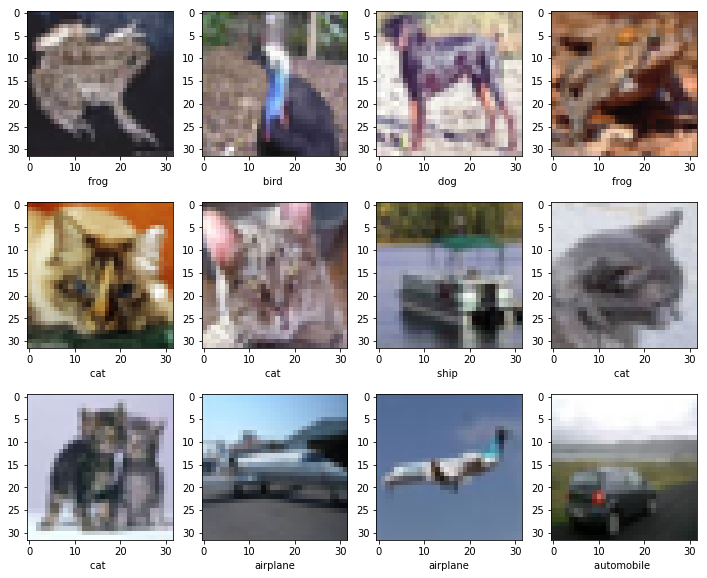

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [3]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [4]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [5]:
import keras, keras.layers as L

Создайте полносвязную сеть:

In [6]:
model = keras.models.Sequential()
model.add(L.InputLayer(input_shape=(32, 32, 3)))
model.add(L.Flatten())
model.add(L.Dense(100, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

In [7]:
dummy_pred = model.predict_proba(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Обучение сети

**Задание 1.1 (1 балл)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [8]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy')
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
40000/40000 [==============================] - 8s 192us/step - loss: 1.9242
Epoch 2/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.7572
Epoch 3/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.6822
Epoch 4/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.6330
Epoch 5/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.5956
Epoch 6/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.5623
Epoch 7/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.5350
Epoch 8/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.5124
Epoch 9/10
40000/40000 [==============================] - 8s 188us/step - loss: 1.4915
Epoch 10/10
40000/40000 [==============================] - 8s 189us/step - loss: 1.4701


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [9]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4665
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (1 балл)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [10]:
model = keras.models.Sequential()
model.add(L.InputLayer(input_shape=(32, 32, 3)))
model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model.add(L.ReLU())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.Flatten())
model.add(L.Dense(100, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

In [11]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy')
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
40000/40000 [==============================] - 11s 279us/step - loss: 1.9192
Epoch 2/10
40000/40000 [==============================] - 10s 252us/step - loss: 1.6523
Epoch 3/10
40000/40000 [==============================] - 10s 250us/step - loss: 1.4970
Epoch 4/10
40000/40000 [==============================] - 10s 252us/step - loss: 1.4006
Epoch 5/10
40000/40000 [==============================] - 10s 256us/step - loss: 1.3368
Epoch 6/10
40000/40000 [==============================] - 10s 252us/step - loss: 1.2857
Epoch 7/10
40000/40000 [==============================] - 10s 253us/step - loss: 1.2390
Epoch 8/10
40000/40000 [==============================] - 10s 254us/step - loss: 1.1987
Epoch 9/10
40000/40000 [==============================] - 10s 254us/step - loss: 1.1618
Epoch 10/10
40000/40000 [==============================] - 10s 256us/step - loss: 1.1278


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [12]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5732
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (0.5 балла)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

In [13]:
from keras.models import clone_model

# Обучаем копию модели и строим графики точности на обучающей и тестовой выборках
def fit_model(model, optimizer, model_name, optimizer_name, **fit_params):
    model = clone_model(model)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=[X_val, y_val], **fit_params)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(model_name + " (" + optimizer_name + ")")
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

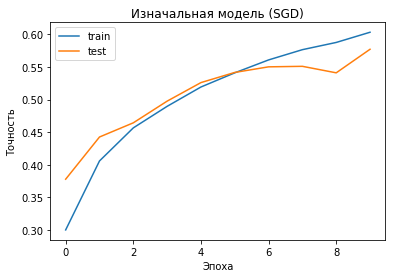

In [14]:
fit_model(model, keras.optimizers.SGD(), "Изначальная модель", "SGD", epochs=10, verbose=0)

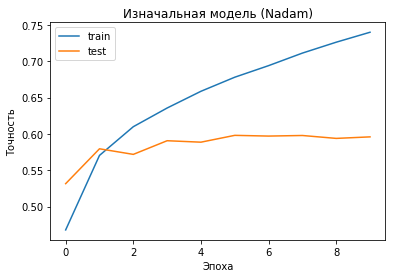

In [15]:
fit_model(model, keras.optimizers.Nadam(), "Изначальная модель", "Nadam", epochs=10, verbose=0)

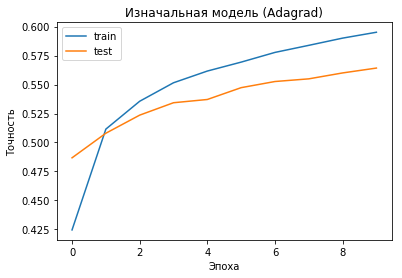

In [16]:
fit_model(model, keras.optimizers.Adagrad(), "Изначальная модель", "Adagrad", epochs=10, verbose=0)

**Задание 1.4 (0.5 балла)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

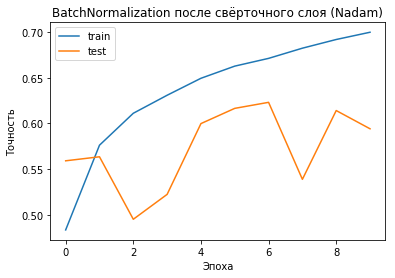

In [17]:
model_conv_batch = keras.models.Sequential()
model_conv_batch.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model_conv_batch.add(L.BatchNormalization())
model_conv_batch.add(L.ReLU())
model_conv_batch.add(L.MaxPool2D(pool_size=(3, 3)))
model_conv_batch.add(L.Flatten())
model_conv_batch.add(L.Dense(100))
model_conv_batch.add(L.ReLU())
model_conv_batch.add(L.Dense(10, activation='softmax'))

fit_model(
    model_conv_batch, keras.optimizers.Nadam(), "BatchNormalization после свёрточного слоя", 
    "Nadam", epochs=10, verbose=0)

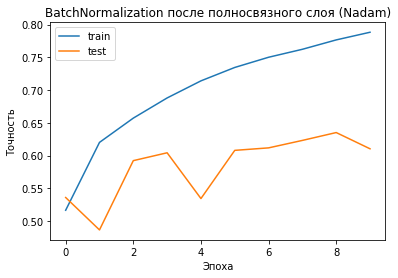

In [18]:
model_dense_batch = keras.models.Sequential()
model_dense_batch.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model_dense_batch.add(L.ReLU())
model_dense_batch.add(L.MaxPool2D(pool_size=(3, 3)))
model_dense_batch.add(L.Flatten())
model_dense_batch.add(L.Dense(100))
model_dense_batch.add(L.BatchNormalization())
model_dense_batch.add(L.ReLU())
model_dense_batch.add(L.Dense(10, activation='softmax'))

fit_model(
    model_dense_batch, keras.optimizers.Nadam(), "BatchNormalization после полносвязного слоя", 
    "Nadam", epochs=10, verbose=0)

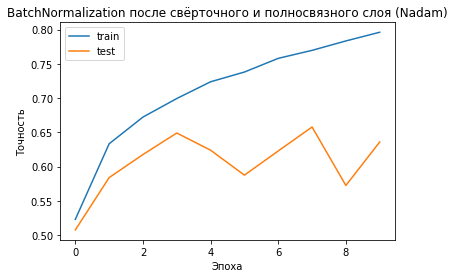

In [19]:
model_all_batch = keras.models.Sequential()
model_all_batch.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model_all_batch.add(L.BatchNormalization())
model_all_batch.add(L.ReLU())
model_all_batch.add(L.MaxPool2D(pool_size=(3, 3)))
model_all_batch.add(L.Flatten())
model_all_batch.add(L.Dense(100))
model_all_batch.add(L.BatchNormalization())
model_all_batch.add(L.ReLU())
model_all_batch.add(L.Dense(10, activation='softmax'))

fit_model(
    model_all_batch, keras.optimizers.Nadam(), "BatchNormalization после свёрточного и полносвязного слоя", 
    "Nadam", epochs=10, verbose=0)

**Задание 1.5 (0.5 балла)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%.

In [20]:
from timeit import default_timer as timer


# Класс наблюдатель за процессом обучения 
# Измеряет время обучения до момента превышения некоторого порога точности
class TimeFitCallback(keras.callbacks.Callback):
    
    def __init__(self, treshhold=0.5):
        self._treshhold = treshhold
    
    def on_train_begin(self, logs={}):
        self._start = timer()
        return
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        print("Эпоха", epoch, "- точность", logs['acc'])
        if logs['acc'] >= self._treshhold:
            end = timer()
            self.model.stop_training = True
            print("\nТочность", self._treshhold, "достигнута за время", end - self._start, "сек")
        return
 
    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return


# Обучаем последнюю модель с разными batch_size
def measure_time(batch_size):
    model = keras.models.Sequential()
    model.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
    model.add(L.BatchNormalization())
    model.add(L.ReLU())
    model.add(L.MaxPool2D(pool_size=(3, 3)))
    model.add(L.Flatten())
    model.add(L.Dense(100))
    model.add(L.BatchNormalization())
    model.add(L.ReLU())
    model.add(L.Dense(10, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    time_call_back = TimeFitCallback(0.55)
    _ = model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=[time_call_back], batch_size=batch_size)

In [21]:
measure_time(8)

Эпоха 0 - точность 0.463
Эпоха 1 - точность 0.551575

Точность 0.55 достигнута за время 119.24659138825714 сек


In [22]:
measure_time(16)

Эпоха 0 - точность 0.522975
Эпоха 1 - точность 0.615

Точность 0.55 достигнута за время 63.12281992967668 сек


In [23]:
measure_time(32)

Эпоха 0 - точность 0.53945
Эпоха 1 - точность 0.632925

Точность 0.55 достигнута за время 35.73013571154263 сек


In [24]:
measure_time(64)

Эпоха 0 - точность 0.53185
Эпоха 1 - точность 0.63235

Точность 0.55 достигнута за время 24.283598806333714 сек


In [25]:
measure_time(128)

Эпоха 0 - точность 0.517625
Эпоха 1 - точность 0.6287

Точность 0.55 достигнута за время 18.321356328543885 сек


In [26]:
measure_time(256)

Эпоха 0 - точность 0.50505
Эпоха 1 - точность 0.60855

Точность 0.55 достигнута за время 15.30038548681074 сек


In [27]:
measure_time(512)

Эпоха 0 - точность 0.4848
Эпоха 1 - точность 0.60695

Точность 0.55 достигнута за время 13.80611347698499 сек


In [28]:
measure_time(1024)

Эпоха 0 - точность 0.44275
Эпоха 1 - точность 0.574425

Точность 0.55 достигнута за время 14.080529281003408 сек


In [29]:
measure_time(2048)

Эпоха 0 - точность 0.401475
Эпоха 1 - точность 0.5390749998092651
Эпоха 2 - точность 0.5880500001907348

Точность 0.55 достигнута за время 19.945772688511738 сек


По соотношению "время обучения - итоговая точность" хорошо показал себя batch_size=128.<br>А лучшие точности при превышении порога 0.55 показали batch_size=32 и batch_size=64

**Задание 1.6 (0.5 балла)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

Кривые обучения можно отсортировать по качеству по следующим критериям:
1. Итоговое качество на тестовой выборке после фиксированного числа итераций (в данном случае 10)
2. Время обучения (в секундах), потребовавшееся, чтобы выйти на наилучший уровень качества


Попробуем соединить предыдущую лучшую модель (BatchNormalization после свёрточного и полносвязного слоя) с новым batch_size=128

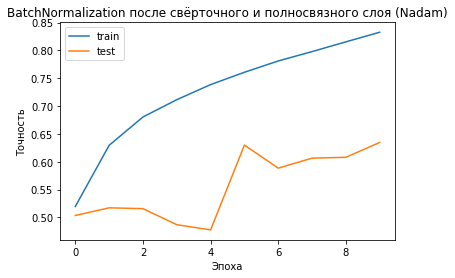

In [30]:
model_all_batch = keras.models.Sequential()
model_all_batch.add(L.Conv2D(filters=10, kernel_size=(3, 3)))
model_all_batch.add(L.BatchNormalization())
model_all_batch.add(L.ReLU())
model_all_batch.add(L.MaxPool2D(pool_size=(3, 3)))
model_all_batch.add(L.Flatten())
model_all_batch.add(L.Dense(100))
model_all_batch.add(L.BatchNormalization())
model_all_batch.add(L.ReLU())
model_all_batch.add(L.Dense(10, activation='softmax'))

fit_model(
    model_all_batch, keras.optimizers.Nadam(), "BatchNormalization после свёрточного и полносвязного слоя", 
    "Nadam", epochs=10, verbose=0, batch_size=128)

Напишите ваши выводы по проделанным экспериментам: что заработало, что — не очень. Постройте график кривых обучения (здесь или выше) с кривыми обучения разных архитектур.

#### Выводы, которые можно сделать на данной обучающей выборке
1. Алгоритм оптимизации Nadam быстрее повышает качество на обучающей выборке, чем SGD или Adagrad
2. Nadam после 10 итераций дал лучшее значение точности на тестовой выборке, а также быстрее всего вышел на данный уровень
3. Использование BatchNormalization после свёрточного и полносвязного слоёв повысило качество сети
4. Приемлимый с точки зрения качества и времени обучения размер batch_size = от нескольких десятков до нескольких сотен примеров

## Свёрточная нейросеть здорового человека

**Задание 1.7 (5 баллов)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 40s 1ms/step - loss: 1.2476 - acc: 0.5588 - val_loss: 1.6930 - val_acc: 0.4581
Epoch 2/10
40000/40000 [==============================] - 38s 953us/step - loss: 0.9613 - acc: 0.6632 - val_loss: 1.2510 - val_acc: 0.5648
Epoch 3/10
40000/40000 [==============================] - 39s 964us/step - loss: 0.8345 - acc: 0.7069 - val_loss: 1.1544 - val_acc: 0.6126
Epoch 4/10
40000/40000 [==============================] - 38s 952us/step - loss: 0.7350 - acc: 0.7439 - val_loss: 1.4045 - val_acc: 0.5581
Epoch 5/10
40000/40000 [==============================] - 38s 953us/step - loss: 0.6523 - acc: 0.7715 - val_loss: 1.1764 - val_acc: 0.6258
Epoch 6/10
40000/40000 [==============================] - 38s 961us/step - loss: 0.5738 - acc: 0.7983 - val_loss: 1.4606 - val_acc: 0.5665
Epoch 7/10
40000/40000 [==============================] - 38s 957us/step - loss: 0.5071 - acc: 0.8225 - val_loss: 1.13

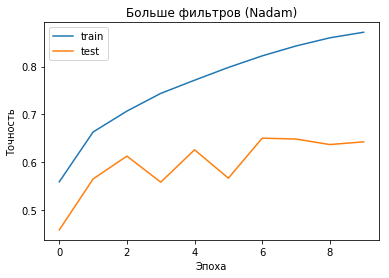

In [31]:
#Попробуем больше фильтров в свёрточном слое
model = keras.models.Sequential()
model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPool2D(pool_size=(3, 3)))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dense(10, activation='softmax'))

fit_model(model, keras.optimizers.Nadam(), "Больше фильтров", "Nadam", epochs=10)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 56s 1ms/step - loss: 1.2106 - acc: 0.5667 - val_loss: 1.9025 - val_acc: 0.3697
Epoch 2/10
40000/40000 [==============================] - 49s 1ms/step - loss: 0.8705 - acc: 0.6948 - val_loss: 1.1057 - val_acc: 0.6107
Epoch 3/10
40000/40000 [==============================] - 49s 1ms/step - loss: 0.7180 - acc: 0.7489 - val_loss: 1.6186 - val_acc: 0.5227
Epoch 4/10
40000/40000 [==============================] - 49s 1ms/step - loss: 0.6075 - acc: 0.7884 - val_loss: 0.9818 - val_acc: 0.6763
Epoch 5/10
40000/40000 [==============================] - 51s 1ms/step - loss: 0.5097 - acc: 0.8219 - val_loss: 1.0744 - val_acc: 0.6638
Epoch 6/10
40000/40000 [==============================] - 50s 1ms/step - loss: 0.4322 - acc: 0.8476 - val_loss: 1.0477 - val_acc: 0.6790
Epoch 7/10
40000/40000 [==============================] - 50s 1ms/step - loss: 0.3666 - acc: 0.8716 - val_loss: 0.9451 - val_acc

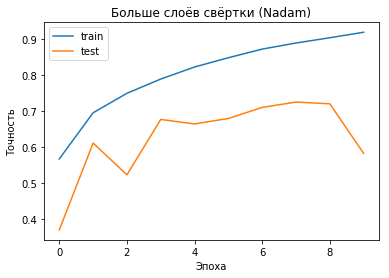

In [145]:
#Попробуем больше слоёв свёртки вместе с max_pooling
model = keras.models.Sequential()

model.add(L.InputLayer((32, 32, 3)))
model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Conv2D(filters=80, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Conv2D(filters=160, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
_ = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=15)

In [154]:
#Попробуем добавить больше нейронов в полносвязном слое, фильтров и Dropout
model = keras.models.Sequential()

model.add(L.InputLayer((32, 32, 3)))
model.add(L.Conv2D(filters=40, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Dropout(0.2))
model.add(L.Conv2D(filters=160, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Dropout(0.2))
model.add(L.Conv2D(filters=640, kernel_size=(3, 3)))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.ReLU())

model.add(L.Flatten())

model.add(L.Dropout(0.2))
model.add(L.Dense(500))
model.add(L.BatchNormalization())
model.add(L.ReLU())

model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Nadam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=15)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 131s 3ms/step - loss: 1.3085 - acc: 0.5382 - val_loss: 1.3259 - val_acc: 0.5398
Epoch 2/15
40000/40000 [==============================] - 125s 3ms/step - loss: 0.9487 - acc: 0.6685 - val_loss: 1.3790 - val_acc: 0.5356
Epoch 3/15
40000/40000 [==============================] - 125s 3ms/step - loss: 0.8005 - acc: 0.7212 - val_loss: 0.8375 - val_acc: 0.7087
Epoch 4/15
40000/40000 [==============================] - 124s 3ms/step - loss: 0.7034 - acc: 0.7528 - val_loss: 0.8031 - val_acc: 0.7185
Epoch 5/15
40000/40000 [==============================] - 124s 3ms/step - loss: 0.6206 - acc: 0.7833 - val_loss: 0.9840 - val_acc: 0.6797
Epoch 6/15
40000/40000 [==============================] - 130s 3ms/step - loss: 0.5434 - acc: 0.8105 - val_loss: 1.0853 - val_acc: 0.6650
Epoch 7/15
40000/40000 [==============================] - 126s 3ms/step - loss: 0.4822 - acc: 0.8311 - val_loss: 0.8561 - 

In [156]:
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.2032 - acc: 0.9284 - val_loss: 0.8905 - val_acc: 0.7670
Epoch 2/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1872 - acc: 0.9338 - val_loss: 1.4985 - val_acc: 0.6696
Epoch 3/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1846 - acc: 0.9358 - val_loss: 1.1540 - val_acc: 0.7260
Epoch 4/5
40000/40000 [==============================] - 126s 3ms/step - loss: 0.1632 - acc: 0.9420 - val_loss: 1.0355 - val_acc: 0.7496
Epoch 5/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1609 - acc: 0.9430 - val_loss: 0.8063 - val_acc: 0.7861


In [157]:
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1637 - acc: 0.9429 - val_loss: 0.9867 - val_acc: 0.7520
Epoch 2/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1465 - acc: 0.9482 - val_loss: 0.8362 - val_acc: 0.7767
Epoch 3/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1435 - acc: 0.9506 - val_loss: 0.9652 - val_acc: 0.7599
Epoch 4/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1375 - acc: 0.9520 - val_loss: 1.1060 - val_acc: 0.7232
Epoch 5/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1345 - acc: 0.9528 - val_loss: 1.2440 - val_acc: 0.729734


In [158]:
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=10)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1289 - acc: 0.9548 - val_loss: 0.8181 - val_acc: 0.8011
Epoch 2/10
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1289 - acc: 0.9560 - val_loss: 0.9274 - val_acc: 0.7876
Epoch 3/10
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1218 - acc: 0.9579 - val_loss: 1.1190 - val_acc: 0.7547
Epoch 4/10
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1207 - acc: 0.9574 - val_loss: 0.9899 - val_acc: 0.7582
Epoch 5/10
40000/40000 [==============================] - 125s 3ms/step - loss: 0.1178 - acc: 0.9590 - val_loss: 1.0442 - val_acc: 0.7598
Epoch 6/10
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1124 - acc: 0.9611 - val_loss: 0.8712 - val_acc: 0.7934
Epoch 7/10
40000/40000 [==============================] - 126s 3ms/step - loss: 0.1106 - acc: 0.9622 - val_loss: 0.7925 - 

In [160]:
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 124s 3ms/step - loss: 0.1058 - acc: 0.9642 - val_loss: 1.0595 - val_acc: 0.7667
Epoch 2/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0979 - acc: 0.9660 - val_loss: 1.0322 - val_acc: 0.7780
Epoch 3/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0948 - acc: 0.9672 - val_loss: 0.8842 - val_acc: 0.7945
Epoch 4/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0953 - acc: 0.9667 - val_loss: 1.2391 - val_acc: 0.7521
Epoch 5/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0969 - acc: 0.9671 - val_loss: 0.9355 - val_acc: 0.7917


In [161]:
history = model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=5)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0905 - acc: 0.9688 - val_loss: 1.1621 - val_acc: 0.7569
Epoch 2/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0895 - acc: 0.9700 - val_loss: 0.9634 - val_acc: 0.7819
Epoch 3/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.0872 - acc: 0.9696 - val_loss: 0.8759 - val_acc: 0.8052
Epoch 4/5
40000/40000 [==============================] - 128s 3ms/step - loss: 0.0871 - acc: 0.9699 - val_loss: 1.0265 - val_acc: 0.7884s - loss: 0.0868 - acc:
Epoch 5/5
40000/40000 [==============================] - 123s 3ms/step - loss: 0.0827 - acc: 0.9717 - val_loss: 1.4961 - val_acc: 0.7184


Не получается выйти на необходимый уровень точности, попробуем применить аугментацию

In [165]:
from keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(rotation_range=10, horizontal_flip=True)
augmenter.fit(X_train)

In [167]:
model.fit_generator(augmenter.flow(X_train, y_train), validation_data=[X_val, y_val], epochs=5)

Epoch 1/5
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4968 - acc: 0.8420 - val_loss: 0.5986 - val_acc: 0.8058
Epoch 2/5
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4333 - acc: 0.8573 - val_loss: 0.5581 - val_acc: 0.8228
Epoch 3/5
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4075 - acc: 0.8635 - val_loss: 0.6774 - val_acc: 0.7931
Epoch 4/5
1250/1250 [==============================] - 122s 98ms/step - loss: 0.3857 - acc: 0.8697 - val_loss: 0.5799 - val_acc: 0.8188
Epoch 5/5
1250/1250 [==============================] - 124s 99ms/step - loss: 0.3644 - acc: 0.8770 - val_loss: 0.5809 - val_acc: 0.8123


Момент истины: проверьте, какого качества достигла ваша сеть.

In [168]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.8167
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

In [169]:
model.save("best.model")

Аугментация повысила уровень точности до необходимых 80%